## Construction premier VAE pour spectrogramme 
...on marque bien les changements avec le notebook 1erTest

In [32]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader 
import os 
import numpy as np

In [33]:
folder_path = "../Data/charly/spectrograms_win800_fra200_rFalse_nfft800_nmelsNone_amptodbTrue/"
all_wav = []
folders_locuteur = os.listdir(folder_path)
for folder in folders_locuteur:
    wav_files = os.listdir(folder_path + folder)
    for wav in wav_files:
        all_wav.append(folder_path + folder + "/" + wav)
np.random.shuffle(all_wav)
print(type(all_wav))

#### attention on ne transpose plus les spectrogrammes 
#### et on les unsqueeze pour passer de 3 à 4 dimensions

<class 'list'>


In [34]:
class SpectroDataset(Dataset):
    """
    A custom dataset to load spectrograms
    """
    def __init__(self, datapath):
        self.path = datapath

# dans le cas où ne peut pas charger toutes les données en RAM en même temps, 
# on charge les données et on les transforme uniquement lors de l'appel de la méthode __getitem__
    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        link = self.path[idx]
        spectro = np.load(link)
        #spectro = np.transpose(spectro)
        spectro = np.expand_dims(spectro, axis=0)
        spectro = torch.from_numpy(spectro)
        return spectro
        

In [35]:
spectro_path = all_wav[:1000]
spectros = SpectroDataset(spectro_path) 
data_loader = DataLoader(spectros,batch_size=16,shuffle=True)

In [36]:
batch = next(iter(data_loader))
print(batch.shape)

torch.Size([16, 1, 401, 21])


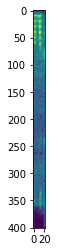

In [37]:
#visualisation batch
import matplotlib.pyplot as plt
plt.imshow(batch[0][0])

## Entrainement d'un VanillaVAE

In [69]:
import importlib as implib

import models.modules.bottleneck as Bottleneck
import models.modules.CNNdecoder as Decoder
import models.modules.CNNencoder as Encoder
import models.vanillaVAE as VAE

implib.reload(Bottleneck)
implib.reload(Decoder)
implib.reload(Encoder)
implib.reload(VAE)

<module 'models.vanillaVAE' from '/home/hippo/Documents/voiceVAE/models/vanillaVAE.py'>

In [70]:
z_dim = 32
encoder = Encoder.vanillaEncoder(z_dim= z_dim)
bottleneck = Bottleneck.vanillaBottleneck(z_dim= z_dim)
decoder = Decoder.vanillaDecoder(z_dim= z_dim)
vVAE = VAE.vanillaVAE(encoder, bottleneck, decoder, beta= 0)

In [73]:
#Training loop
num_epochs = 5
device = 'cpu'
outputs = []

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(vVAE.parameters(), lr=1e-3, weight_decay=1e-5)

for epoch in range(num_epochs):
    i=0
    print(f'Epoch {epoch+1}/{num_epochs}')
    for batch in data_loader:
        i+=1
        results = vVAE(batch)
        recon = results['logits']
        # mu = results['mu']
        # logvar = results['logvar']
        loss, details = vVAE.minibatch_loss(batch=batch, device= device)
        #loss = criterion(recon, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if batch % 10 == 0:
        print('batch', i , 'over' ,len(data_loader))
        

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, batch, recon))

Epoch 1/5


KeyboardInterrupt: 

## Visualisation resultats

In [ ]:
print(recon.keys())
recon['latent_variables'].shape

<class 'dict'>


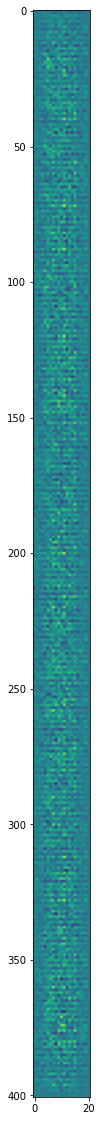

In [42]:
recon = vVAE(batch)

#on affiche recon et original cote à cote
# fig, axes = plt.subplots(nrows=2, ncols=1, sharey=True, sharex=True, figsize=(24,7))
# for images, row in zip([batch, recon['logits']], axes):
#     for img, ax in zip(images, row):
#         ax.imshow(img.detach().numpy())
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)





plt.figure(figsize=(60, 20))
plt.imshow(recon['logits'][0][0].detach().numpy())
#ajustement taille des images

